In [1]:
import accelerate, transformers
print("accelerate:", accelerate.__version__)
print("transformers:", transformers.__version__)

accelerate: 1.12.0
transformers: 4.57.3


In [3]:
import pandas as pd
import numpy as np
import json
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    classification_report,
    confusion_matrix
)

from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ============================================================
# GOOGLE COLAB SETUP
# ============================================================

# Check GPU
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Mount Google Drive (uncomment if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set your data path
DATA_PATH = '/content/drive/MyDrive/EA_RoBERTa/data/processed/gate/'  # MODIFY THIS!

# Verify files exist
print("\nFiles found:")
for f in os.listdir(DATA_PATH):
    print(f"  - {f}")

GPU available: True
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB
Mounted at /content/drive

Files found:
  - train_original.csv
  - config.json
  - val.csv
  - label_mappings.json
  - train_oversampled.csv
  - test.csv
  - tfidf_gating.joblib


In [5]:
# ============================================================
# 1. LOAD DATA
# ============================================================

train_df = pd.read_csv(f'{DATA_PATH}train_oversampled.csv')
val_df = pd.read_csv(f'{DATA_PATH}val.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')

print(f"✅ Data loaded:")
print(f"   Train: {len(train_df):,}")
print(f"   Val:   {len(val_df):,}")
print(f"   Test:  {len(test_df):,}")

# Show columns to debug
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Val columns: {val_df.columns.tolist()}")

✅ Data loaded:
   Train: 32,172
   Val:   2,000
   Test:  2,000

Train columns: ['text', 'label', 'label_str', 'text_filtered']
Val columns: ['text', 'label_str', 'label', 'text_original', 'text_filtered']


In [6]:
# ============================================================
# 2. LOAD LABEL MAPPINGS (with fallback for missing keys)
# ============================================================

with open(f'{DATA_PATH}label_mappings.json', 'r') as f:
    mappings = json.load(f)

print("Keys in label_mappings.json:", list(mappings.keys()))

# Get label_to_id
label_to_id = mappings['label_to_id']

# Get id_to_label (convert string keys to int)
id_to_label = {int(k): v for k, v in mappings['id_to_label'].items()}

# Get label_list - with fallback if missing!
if 'label_list' in mappings:
    label_list = mappings['label_list']
else:
    # Reconstruct from label_to_id (sorted by id)
    label_list = [label for label, idx in sorted(label_to_id.items(), key=lambda x: x[1])]
    print("⚠️ 'label_list' not found in JSON, reconstructed from label_to_id")

# Get num_labels
NUM_LABELS = mappings.get('num_labels', len(label_to_id))

print(f"\n✅ Labels loaded:")
print(f"   label_list: {label_list}")
print(f"   num_labels: {NUM_LABELS}")
print(f"   label_to_id: {label_to_id}")

Keys in label_mappings.json: ['label_to_id', 'id_to_label', 'num_labels']
⚠️ 'label_list' not found in JSON, reconstructed from label_to_id

✅ Labels loaded:
   label_list: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
   num_labels: 6
   label_to_id: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [7]:
# ============================================================
# 3. FIX COLUMN NAMES (handle 'label' vs 'label_id')
# ============================================================

# The Dataset class expects 'label_id', but preprocessing might save as 'label'
# Let's standardize to 'label'

def fix_label_column(df):
    """Ensure we have a 'label' column with integer values."""
    if 'label_id' in df.columns and 'label' not in df.columns:
        df['label'] = df['label_id']
        print("  Copied 'label_id' -> 'label'")
    elif 'label' not in df.columns:
        # Try to create from label_str
        if 'label_str' in df.columns:
            df['label'] = df['label_str'].map(label_to_id)
            print("  Created 'label' from 'label_str'")
        else:
            raise ValueError("Cannot find label column!")
    return df

print("Fixing label columns...")
train_df = fix_label_column(train_df)
val_df = fix_label_column(val_df)
test_df = fix_label_column(test_df)

print(f"\n✅ Label columns fixed")
print(f"   Train labels range: [{train_df['label'].min()}, {train_df['label'].max()}]")
print(f"   Sample: {train_df[['text', 'label']].head(2).to_dict()}")

Fixing label columns...

✅ Label columns fixed
   Train labels range: [0, 5]
   Sample: {'text': {0: 'i did not feel humiliated', 1: 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'}, 'label': {0: 4, 1: 4}}


In [8]:
# ============================================================
# 4. LOAD CONFIG
# ============================================================

with open(f'{DATA_PATH}config.json', 'r') as f:
    config = json.load(f)

MODEL_NAME = config.get('model_name', 'roberta-base')
MAX_LENGTH = config.get('max_length', 128)

print(f"✅ Config: model={MODEL_NAME}, max_len={MAX_LENGTH}")

✅ Config: model=roberta-base, max_len=128


In [9]:
# ============================================================
# 5. TOKENIZER
# ============================================================

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
print(f"✅ Tokenizer loaded: {MODEL_NAME}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✅ Tokenizer loaded: roberta-base


In [10]:
# ============================================================
# 6. DATASET CLASS
# ============================================================

class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].tolist()
        # Use 'label' column (we fixed this above)
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,  # Dynamic padding via collator
            return_tensors=None
        )

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': label
        }

In [11]:
# ============================================================
# 7. CREATE DATASETS
# ============================================================

train_dataset = EmotionDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset = EmotionDataset(val_df, tokenizer, MAX_LENGTH)
test_dataset = EmotionDataset(test_df, tokenizer, MAX_LENGTH)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset):,}")
print(f"   Val:   {len(val_dataset):,}")
print(f"   Test:  {len(test_dataset):,}")

# Verify a sample
sample = train_dataset[0]
print(f"\nSample check:")
print(f"   input_ids length: {len(sample['input_ids'])}")
print(f"   label: {sample['labels']} ({id_to_label[sample['labels']]})")

✅ Datasets created:
   Train: 32,172
   Val:   2,000
   Test:  2,000

Sample check:
   input_ids length: 7
   label: 4 (sadness)


In [12]:
# ============================================================
# 8. DATA COLLATOR
# ============================================================

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors='pt'
)

print(f"✅ DataCollator configured")

✅ DataCollator configured


In [13]:
# ============================================================
# 9. MODEL CONFIGURATION
# ============================================================

BASELINE_CONFIG = {
    'model_name': 'roberta-base',
    'learning_rate': 1e-5,
    'batch_size': 32,
    'num_epochs': 10,
    'dropout': 0.3,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'max_length': MAX_LENGTH,
    'num_labels': NUM_LABELS
}

# Create id2label and label2id for model config
id2label = id_to_label
label2id = label_to_id

print("\nModel Configuration:")
for k, v in BASELINE_CONFIG.items():
    print(f"   {k}: {v}")


Model Configuration:
   model_name: roberta-base
   learning_rate: 1e-05
   batch_size: 32
   num_epochs: 10
   dropout: 0.3
   weight_decay: 0.01
   warmup_ratio: 0.1
   max_length: 128
   num_labels: 6


In [14]:
# ============================================================
# 10. CREATE MODEL
# ============================================================

os.makedirs('models/baseline_roberta', exist_ok=True)
os.makedirs('reports', exist_ok=True)

model = RobertaForSequenceClassification.from_pretrained(
    BASELINE_CONFIG['model_name'],
    num_labels=BASELINE_CONFIG['num_labels'],
    hidden_dropout_prob=BASELINE_CONFIG['dropout'],
    attention_probs_dropout_prob=BASELINE_CONFIG['dropout'],
    id2label=id2label,
    label2id=label2id
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model loaded on {device}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded on cuda
   Total parameters: 124,650,246
   Trainable parameters: 124,650,246


In [15]:
# ============================================================
# 11. COMPUTE METRICS FUNCTION
# ============================================================

def compute_metrics(eval_pred):
    """Compute metrics for evaluation."""
    predictions, labels = eval_pred

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    predictions = np.argmax(predictions, axis=1)

    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    # Macro metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )

    # MCC
    mcc = matthews_corrcoef(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'mcc': mcc
    }

print("✅ compute_metrics function defined")

✅ compute_metrics function defined


In [16]:
# ============================================================
# 12. TRAINING ARGUMENTS
# ============================================================

training_args = TrainingArguments(
    output_dir='./results/baseline_roberta',

    # Training params
    num_train_epochs=BASELINE_CONFIG['num_epochs'],
    per_device_train_batch_size=BASELINE_CONFIG['batch_size'],
    per_device_eval_batch_size=BASELINE_CONFIG['batch_size'],
    learning_rate=BASELINE_CONFIG['learning_rate'],
    weight_decay=BASELINE_CONFIG['weight_decay'],
    warmup_ratio=BASELINE_CONFIG['warmup_ratio'],

    # Evaluation & Saving
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,

    # Logging
    logging_dir='./logs/baseline_roberta',
    logging_steps=100,
    logging_first_step=True,

    # Optimizations
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,

    # Other
    report_to='none',
    seed=42,
    save_total_limit=2
)

print("✅ TrainingArguments configured")

✅ TrainingArguments configured


In [17]:
# ============================================================
# 13. CREATE TRAINER
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✅ Trainer created")
print(f"\n📊 Training info:")
print(f"   Train samples: {len(train_dataset):,}")
print(f"   Val samples: {len(val_dataset):,}")
print(f"   Batches per epoch: {len(train_dataset) // BASELINE_CONFIG['batch_size']}")
print(f"   Total steps: {len(train_dataset) // BASELINE_CONFIG['batch_size'] * BASELINE_CONFIG['num_epochs']}")

✅ Trainer created

📊 Training info:
   Train samples: 32,172
   Val samples: 2,000
   Batches per epoch: 1005
   Total steps: 10050


/tmp/ipython-input-3457339694.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# ============================================================
# 14. TRAIN
# ============================================================

print("=" * 60)
print("🚀 STARTING BASELINE RoBERTa TRAINING")
print("=" * 60)
print(f"   Device: {device}")
print(f"   Epochs: {BASELINE_CONFIG['num_epochs']}")
print(f"   Batch size: {BASELINE_CONFIG['batch_size']}")
print(f"   Learning rate: {BASELINE_CONFIG['learning_rate']}")
print("=" * 60)

train_result = trainer.train()

print("\n✅ Training complete!")
print(f"   Training Loss: {train_result.training_loss:.4f}")
print(f"   Training Time: {train_result.metrics['train_runtime']:.1f}s")

🚀 STARTING BASELINE RoBERTa TRAINING
   Device: cuda
   Epochs: 10
   Batch size: 32
   Learning rate: 1e-05


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Macro,Recall Macro,F1 Macro,Mcc
1,1.173700,1.072575,0.568000,0.706000,0.568000,0.573942,0.581167,0.674375,0.571195,0.500816
2,0.458800,0.507421,0.843500,0.872775,0.843500,0.848390,0.785740,0.883081,0.819198,0.805288
3,0.331100,0.372090,0.891500,0.904001,0.891500,0.893016,0.845342,0.911805,0.871295,0.862388
4,0.257900,0.383883,0.894500,0.911303,0.894500,0.896876,0.843231,0.920837,0.872403,0.867292
5,0.247800,0.297633,0.910000,0.920379,0.910000,0.911906,0.862383,0.927955,0.889006,0.885134
6,0.200500,0.271451,0.917500,0.926796,0.917500,0.919152,0.872207,0.935166,0.898171,0.894604
7,0.169600,0.272222,0.917500,0.926198,0.917500,0.919078,0.871537,0.931831,0.896614,0.894438
8,0.161800,0.248035,0.922000,0.930530,0.922000,0.923589,0.876041,0.936598,0.900930,0.900100
9,0.171700,0.269081,0.918000,0.926926,0.918000,0.919601,0.873106,0.933820,0.898182,0.895141
10,0.178000,0.261849,0.921000,0.929382,0.921000,0.922533,0.876363,0.935183,0.900757,0.898836



✅ Training complete!
   Training Loss: 0.4186
   Training Time: 487.8s


In [19]:
# ============================================================
# 15. SAVE MODEL
# ============================================================

trainer.save_model('./models/baseline_roberta')
tokenizer.save_pretrained('./models/baseline_roberta')

print("✅ Model saved to ./models/baseline_roberta/")

✅ Model saved to ./models/baseline_roberta/


In [20]:
# ============================================================
# 16. EVALUATE ON VALIDATION SET
# ============================================================

print("\n" + "=" * 60)
print("📊 VALIDATION SET EVALUATION")
print("=" * 60)

val_results = trainer.evaluate(val_dataset)

print("\nValidation Results:")
for key, value in val_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")


📊 VALIDATION SET EVALUATION



Validation Results:
   eval_loss: 0.2480
   eval_accuracy: 0.9220
   eval_precision_weighted: 0.9305
   eval_recall_weighted: 0.9220
   eval_f1_weighted: 0.9236
   eval_precision_macro: 0.8760
   eval_recall_macro: 0.9366
   eval_f1_macro: 0.9009
   eval_mcc: 0.9001
   eval_runtime: 3.7157
   eval_samples_per_second: 538.2600
   eval_steps_per_second: 16.9550
   epoch: 10.0000


In [21]:
# ============================================================
# 17. EVALUATE ON TEST SET
# ============================================================

print("\n" + "=" * 60)
print("📊 TEST SET EVALUATION")
print("=" * 60)

test_results = trainer.evaluate(test_dataset)

print("\nTest Results:")
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")


📊 TEST SET EVALUATION



Test Results:
   eval_loss: 0.2358
   eval_accuracy: 0.9140
   eval_precision_weighted: 0.9269
   eval_recall_weighted: 0.9140
   eval_f1_weighted: 0.9167
   eval_precision_macro: 0.8513
   eval_recall_macro: 0.9249
   eval_f1_macro: 0.8791
   eval_mcc: 0.8896
   eval_runtime: 1.1005
   eval_samples_per_second: 1817.3930
   eval_steps_per_second: 57.2480
   epoch: 10.0000


In [22]:
# ============================================================
# 18. DETAILED ANALYSIS
# ============================================================

print("\n" + "=" * 60)
print("📊 DETAILED TEST SET ANALYSIS")
print("=" * 60)

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array([test_dataset[i]['labels'] for i in range(len(test_dataset))])

# Classification Report
print("\n📋 Classification Report:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=label_list))


📊 DETAILED TEST SET ANALYSIS



📋 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.89      0.94      0.91       275
        fear       0.89      0.85      0.87       224
         joy       0.99      0.89      0.94       695
        love       0.73      0.98      0.84       159
     sadness       0.97      0.94      0.95       581
    surprise       0.64      0.95      0.76        66

    accuracy                           0.91      2000
   macro avg       0.85      0.92      0.88      2000
weighted avg       0.93      0.91      0.92      2000



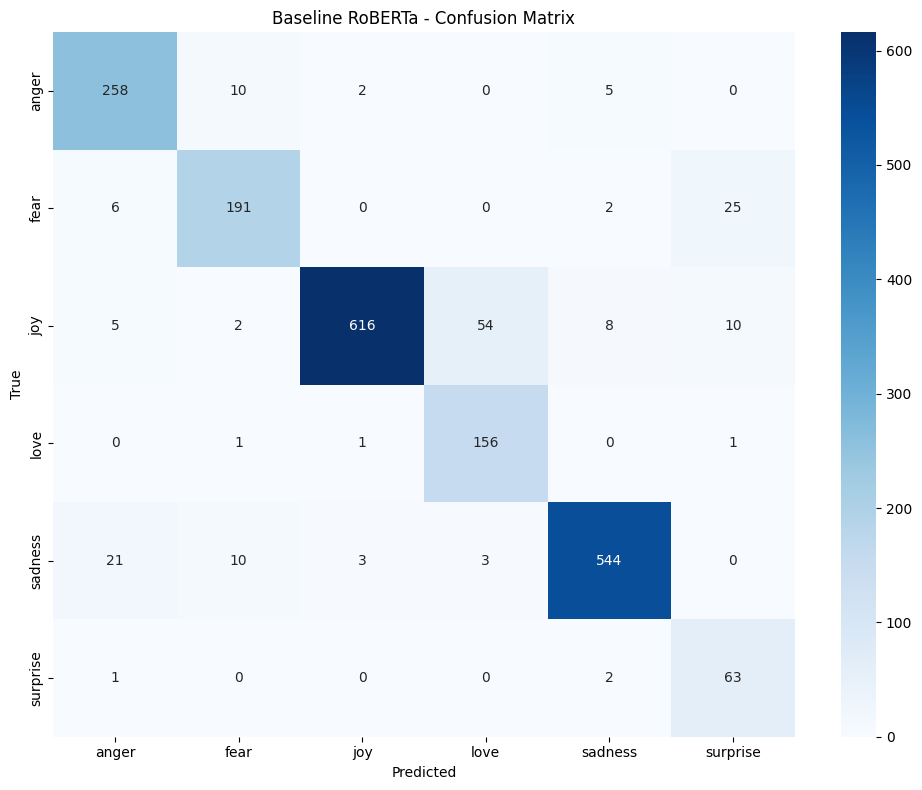


✅ Confusion matrix saved to reports/baseline_confusion_matrix.png


In [23]:
# ============================================================
# 19. CONFUSION MATRIX
# ============================================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_list,
    yticklabels=label_list
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline RoBERTa - Confusion Matrix')
plt.tight_layout()
plt.savefig('reports/baseline_confusion_matrix.png', dpi=150)
plt.show()

print("\n✅ Confusion matrix saved to reports/baseline_confusion_matrix.png")

In [24]:
# ============================================================
# 20. SAVE RESULTS
# ============================================================

results = {
    'config': BASELINE_CONFIG,
    'validation': {k: float(v) if isinstance(v, (float, np.floating)) else v
                   for k, v in val_results.items()},
    'test': {k: float(v) if isinstance(v, (float, np.floating)) else v
             for k, v in test_results.items()}
}

with open('reports/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Results saved to reports/baseline_results.json")

# Summary
print("\n" + "=" * 60)
print("📊 FINAL SUMMARY")
print("=" * 60)
print(f"\nTest Accuracy:    {test_results['eval_accuracy']:.4f}")
print(f"Test F1 Weighted: {test_results['eval_f1_weighted']:.4f}")
print(f"Test MCC:         {test_results['eval_mcc']:.4f}")

✅ Results saved to reports/baseline_results.json

📊 FINAL SUMMARY

Test Accuracy:    0.9140
Test F1 Weighted: 0.9167
Test MCC:         0.8896
